In [37]:
#数据导入
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import sklearn.preprocessing as prep
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'  #禁止warning
mnist=input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [102]:
#构造自编码类
class AdditiveGaussianNioseAutoencoder(object):
    def __init__(self,n_input,n_hidden,transfer_function=tf.nn.softplus,
                optimizer=tf.train.AdadeltaOptimizer(),scale=0.1):
        '''
        :param n_input: 输入节点数
        :param n_hidden: 隐层节点数
        :param transfer_function: 隐层激活函数
        :param optimizer: 优化器
        :param scale: 高斯噪声方差
        '''
        self.n_input=n_input
        self.n_hidden=n_hidden
        self.transfer=transfer_function
        self.training_scale=scale
        self.weights=dict()
        
        with tf.name_scope('RawInput'):
            self.x=tf.placeholder(tf.float32,[None,self.n_input])
        with tf.name_scope('NoiseAdder'):
            self.scale=tf.placeholder(tf.float32)
            self.noise=self.x+self.scale*tf.random.normal((n_input,)) 
        
        with tf.name_scope('Encoder'):
            self.weights['w1']=tf.Variable(xavier_init(self.n_input,self.n_hidden),name='w1')
            self.weights['b1']=tf.Variable(tf.zeros([self.n_hidden],dtype=tf.float32),name='b1')
            self.hidden=self.transfer(tf.add(tf.matmul(self.noise,
                                                       self.weights['w1']),self.weights['b1']))
        with tf.name_scope('Reconstruction'):
            self.weights['w2']=tf.Variable(tf.zeros([self.n_hidden,self.n_input],
                                                    dtype=tf.float32),name='w2')
            self.weights['b2']=tf.Variable(tf.zeros([self.n_input],dtype=tf.float32),name='b2')
            self.reconstruction=self.transfer(tf.add(tf.matmul(self.hidden,self.weights['w2']),
                                                  self.weights['b2']))
        #损失：重构信号和原信号的误差平方和
        with tf.name_scope('Loss'):
            self.cost=0.5*tf.reduce_mean(tf.pow(self.x-self.reconstruction,2))
        with tf.name_scope('Train'):
            self.optimizer=optimizer.minimize(self.cost)
        
        init=tf.global_variables_initializer()
        self.sess=tf.Session()
        self.sess.run(init)
        print('begin to run session...')
        
    #输出噪音干扰项
    def noise_image(self,X):
        return self.sess.run(self.noise,feed_dict={self.x:X,self.scale:self.training_scale})
    #在批次上训练模型
    def partial_fit(self,X):
        cost,opt=self.sess.run((self.cost,self.optimizer),
                               feed_dict={self.x:X,self.scale:self.training_scale})
        return cost
    
    #在给定的样本集合上计算损失（用于测试阶段）
    def calc_total_cost(self,X):
        return self.sess.run(self.cost,feed_dict={self.x:X,self.scale:self.training_scale})
    
    #返回自编码层的输出结果,获得抽象后的高阶特征表示
    def transform(self,X):
        return self.sess.run(self.hidden,feed_dict={self.x:X,self.scale:self.training_scale})
    
    #将隐层的高阶特征作为输入，将其重构为原始输入数据
    def generate(self,hidden=None):
        if hidden==None:
            hidden=np.random.normal(size=self.weights['b1'])
        return self.sess.run(self.reconstruction,feed_dict={self.hidden:hidden})
    
    #整体运行一遍前向复原过程，包括提取高阶特征以及重构原始数据，输入原始数据，输出重构后的数据
    def reconstruction(self,X):
        return self.sess.run(self.reconstruction,feed_dict={self.x:X,
                                                             self.scale:self.training_scale})
    # 获取隐层的权重
    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    # 获取隐层偏置
    def getBiases(self):
        return self.sess.run(self.weights['b1'])
    
# Xavier均匀初始化
# fan_in输入节点数量，fan_out输出节点数量
# 均匀分布方差为(low+high)^2/12=2/(fan_in+fan_out)  所以区间为(low,high)
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))  # 由方差得到上下界
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

#类的实例化
AGN_AE=AdditiveGaussianNioseAutoencoder(n_input=784,n_hidden=200,
                                        transfer_function=tf.nn.softplus,
                                        optimizer=tf.train.AdadeltaOptimizer(learning_rate=0.01),
                                       scale=0.5)

begin to run session...


In [108]:
generate_image=AGN_AE.reconstruction(X_train)
print(type(generate_image))
print('重构图像')
plt.figure(figsize=(10,2))
for i in range(n):
    ax=plt.subplot(1,n,i+1)
    plt.imshow(generate_image[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

TypeError: 'Tensor' object is not callable

原图像


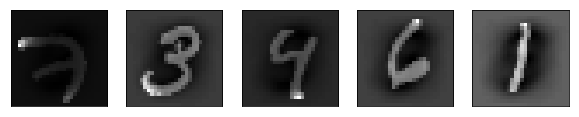

噪音图像


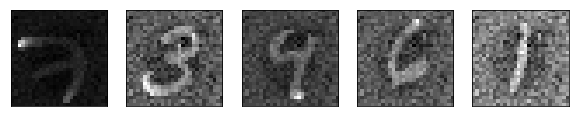

TypeError: 'Tensor' object is not callable

In [107]:
noise_image=AGN_AE.noise_image(X_train[:10])
n=5

print('原图像')
plt.figure(figsize=(10,2))
for i in range(n):
    ax=plt.subplot(1,n,i+1)
    plt.imshow(X_train[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print('噪音图像')
plt.figure(figsize=(10,2))
for i in range(n):
    ax=plt.subplot(1,n,i+1)
    plt.imshow(noise_image[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

generate_image=AGN_AE.reconstruction(X_train)
print(type(generate_image))
print('重构图像')
plt.figure(figsize=(10,2))
for i in range(n):
    ax=plt.subplot(1,n,i+1)
    plt.imshow(generate_image[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
print('把计算图写事件文件，在TensorBoard里面查看')
writer = tf.summary.FileWriter(logdir='logs', graph=AGN_AE.sess.graph)
writer.close()

In [44]:
#数据标准化处理
def standard_scale(X_train,X_test):
    preprocess=prep.StandardScaler().fit(X_train)
    X_train=preprocess.transform(X_train)
    X_test=preprocess.transform(X_test)
    return X_train,X_test

In [36]:
#获取随机的block数据
def get_random_block_from_data(data,batch_size):
    start_index=np.random.randint(0,len(data)-batch_size)
    return data[start_index:(start_index+batch_size)]

In [43]:
mnist.train.images.shape

(55000, 784)

In [84]:
#定义训练参数并训练
X_train,X_test=standard_scale(mnist.train.images[:500],mnist.test.images[:100])

n_samples=int(mnist.train.num_examples)
batch_size=128
epoch=10
display_step=3
for epo in range(epoch):
    avg_cost=0
    total_batch=int(n_samples//batch)
    for i in range(total_batch):
        batch_xs=get_random_block_from_data(X_train,batch_size)
        cost=AGN_AE.partial_fit(batch_xs)
        avg_cost+=cost/batch_size
    avg_cost/=total_batch
    
    if epo%display_step==0:
        print('epoch:%04d,cost=:%.9f' %(epo+1,avg_cost))
#print("Total cost:" + str(autoencoder.calc_total_cost(X_test)))

epoch:0001,cost=:0.004509243
epoch:0004,cost=:0.003662300


KeyboardInterrupt: 

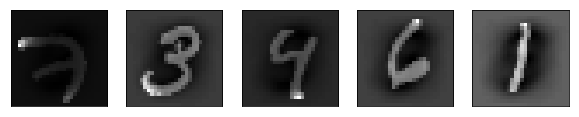

In [66]:
#看一下加噪之后的效果
import matplotlib.pyplot as plt
%matplotlib inline

n=5
plt.figure(figsize=(10,2))
for i in range(n):
    ax=plt.subplot(1,n,i+1)
    plt.imshow(X_train[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
print('噪音图片')
        
        with tf.Session() as sess:  
            plt.figure(figsize=(10,2))
            j=0
            for i in self.noise[:5].eval():
                ax=plt.subplot(1,n,j+1)
                j+=1
                plt.imshow(i.reshape(28,28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                plt.show()

In [10]:
print(mnist.train.num_examples)
print(mnist.validation.num_examples)
print(mnist.test.num_examples)  #查看每个集合的样本数目

55000
5000
10000


In [12]:
print(mnist.train.labels)
#使用train.labels返回标签集合

[7 3 4 ... 5 6 8]


In [13]:
#使用 train.labels 函数返回 mnist 数据集标签
#使用 train.images 函数返回 mnist 数据集图片像素值
#使用 mnist.train.next_batch() 函数将数据输入神经网络
batch=200
xs,ys=mnist.train.next_batch(batch)
print(xs.shape)
print(ys.shape)

(200, 784)
(200,)


In [14]:
import numpy as np

In [19]:
x_train,_=mnist.train.next_batch(5000)
x_test,_=mnist.test.next_batch(1000)

x_train=x_train.astype('float32')/255
x_test=x_test.astype('float32')/255

x_train=np.reshape(x_train,(len(x_train),28,28,1))
x_test=np.reshape(x_test,(len(x_test),28,28,1))
#转化为四维的张量

In [28]:
#添加随机白噪声，并限制加噪后像素值仍处于0-1之间
noise_factor=0.3
x_train_noisy=x_train+noise_factor*np.random.normal(loc=0.0,scale=1.0,size=x_train.shape)
x_test_noisy=x_test+noise_factor*np.random.normal(loc=0.0,scale=1.0,size=x_test.shape)

x_train_noisy=np.clip(x_train_noisy,0.,1.)
x_test_noisy=np.clip(x_test_noisy,0.,1.)

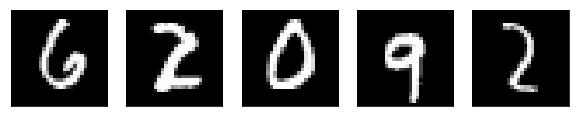

In [29]:
#看一下加噪之后的效果
import matplotlib.pyplot as plt
%matplotlib inline

n=5
plt.figure(figsize=(10,2))
for i in range(n):
    ax=plt.subplot(1,n,i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

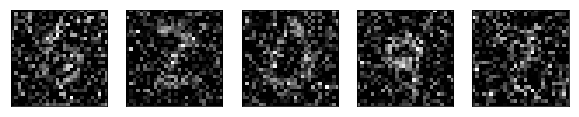

In [35]:
#添加随机白噪声，并限制加噪后像素值仍处于0-1之间
noise_factor=0.3
x_train_noisy=x_train+noise_factor*np.random.normal(loc=0.0,scale=0.01,size=x_train.shape)
x_test_noisy=x_test+noise_factor*np.random.normal(loc=0.0,scale=0.01,size=x_test.shape)

x_train_noisy=np.clip(x_train_noisy,0.,1.)
x_test_noisy=np.clip(x_test_noisy,0.,1.)
#看一下加噪之后的效果
import matplotlib.pyplot as plt
%matplotlib inline

n=5
plt.figure(figsize=(10,2))
for i in range(n):
    ax=plt.subplot(1,n,i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_image=tf.placeholder('tf.float32',[None,28,28,1])
